In [ ]:
!pip install pmdarima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from google.colab import files

# Upload the original CSV (ecommerce_sales_34500.csv)
uploaded = files.upload()   # choose ecommerce_sales_34500.csv [web:20][web:29]

# 1. Load raw data
df_raw = pd.read_csv('ecommerce_sales_34500.csv')

# 2. Keep only needed columns
cols_to_keep = ['product_id', 'quantity', 'order_date']
df_clean = df_raw[cols_to_keep].copy()

# 3. Fix order_date to proper datetime
df_clean['order_date'] = pd.to_datetime(df_clean['order_date'], errors='coerce')  # [web:11]

# 4. Drop rows with invalid dates
df_clean = df_clean.dropna(subset=['order_date'])

# 5. Clean quantity (numeric, no negatives)
df_clean['quantity'] = pd.to_numeric(df_clean['quantity'], errors='coerce')
df_clean['quantity'] = df_clean['quantity'].fillna(0)
df_clean.loc[df_clean['quantity'] < 0, 'quantity'] = 0

# 6. Drop duplicate rows
df_clean = df_clean.drop_duplicates()

# 7. Create extra date columns: day, month, year, month_year
df_clean['order_day'] = df_clean['order_date'].dt.day          # 1–31 [web:26]
df_clean['order_month'] = df_clean['order_date'].dt.month      # 1–12 [web:19]
df_clean['order_year'] = df_clean['order_date'].dt.year        # 4-digit year [web:19]
df_clean['order_month_year'] = df_clean['order_date'].dt.to_period('M').astype(str)  # YYYY-MM [web:1][web:21]

# 8. Quick check
print(df_clean.head())
print(df_clean.info())



   ---------------------------------------- 0.0/722.6 kB ? eta -:--:--
   -------------- ------------------------- 262.1/722.6 kB ? eta -:--:--
   ---------------------------------------- 722.6/722.6 kB 3.3 MB/s  0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 13.3 MB/s  0:00:00

   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   -----

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# 2. DIM_DATE
date_min, date_max = df_clean['order_date'].min(), df_clean['order_date'].max()
print("Date range in df_clean:", date_min, "to", date_max)

dim_date = pd.DataFrame({'date_key': pd.date_range(date_min, date_max, freq='D')})
dim_date['year'] = dim_date['date_key'].dt.year
dim_date['month'] = dim_date['date_key'].dt.month
dim_date['month_name'] = dim_date['date_key'].dt.month_name()
dim_date['month_year'] = dim_date['date_key'].dt.to_period('M').astype(str)

# 3. DIM_PRODUCT with names
product_ids = df_clean['product_id'].dropna().unique()

dim_product = pd.DataFrame({
    'product_key': range(1, len(product_ids) + 1),
    'product_id': product_ids
})

dim_product['product_name'] = ['Product ' + str(i) for i in range(1, len(product_ids) + 1)]

motor_names = [
    'Engine Oil 10W-40',
    'Engine Oil 5W-30',
    'Engine Oil 15W-40',
    'Engine Oil Fully Synthetic',
    'Transmission Fluid ATF',
    'Synthetic Gear Oil',
    'Manual Gear Oil 80W-90',
    'Brake Fluid DOT 3',
    'Brake Fluid DOT 4',
    'Brake Pads Front Set',
    'Brake Pads Rear Set',
    'Brake Shoes Rear Set',
    'Brake Disc Rotor Front',
    'Brake Disc Rotor Rear',
    'Spark Plug Standard',
    'Spark Plug Iridium',
    'Spark Plug Platinum',
    'Ignition Coil Pack',
    'Motorcycle Chain',
    'Chain Lube Spray',
    'Drive Belt',
    'Timing Belt Kit',
    'Air Filter',
    'Cabin Air Filter',
    'Oil Filter',
    'Fuel Filter',
    'Diesel Fuel Filter',
    'Radiator Coolant',
    'Coolant Concentrate',
    'Radiator Hose Upper',
    'Radiator Hose Lower',
    'Water Pump Assembly',
    'Motorcycle Tire Front',
    'Motorcycle Tire Rear',
    'All-Season Car Tire',
    'Battery 12V 5Ah',
    'Battery 12V 9Ah',
    'Battery 12V 45Ah',
    'Battery 12V 60Ah',
    'Clutch Plate Set',
    'Clutch Master Cylinder',
    'Clutch Slave Cylinder',
    'Headlight Bulb LED',
    'Headlight Assembly',
    'Tail Light Assembly',
    'Fog Light Lamp',
    'Starter Motor',
    'Alternator Assembly',
    'Wiper Blade 16 inch',
    'Wiper Blade 20 inch',
    'Car Shampoo',
    'Wax and Polish Kit',
    'Engine Degreaser',
    'Tyre Pressure Gauge',
    'Hydraulic Jack 2 Ton',
    'Hydraulic Jack 5 Ton',
    'Floor Mat Rubber Set',
    'Steering Wheel Cover',

    "Turbo Wastegate Actuator",
    "Intake Air Temperature Sensor",
    "Knock Sensor",
    "Fuel Tank Cap Locking",
    "Fuel Tank Sending Unit",
    "Evaporative Emission Canister",
    "Evap Purge Valve",
    "Radiator Fan Shroud",
    "Heater Hose Inlet",
    "Heater Hose Outlet",
    "Oil Cooler Assembly",
    "Power Steering Hose High Pressure",
    "Power Steering Hose Return",
    "Steering Column Switch",
    "Combination Switch (Lights/Wipers)",
    "Headlight Leveling Motor",
    "Daytime Running Light Module",
    "Fog Light Bezel",
    "Wheel Speed Sensor Front Left",
    "Wheel Speed Sensor Front Right",
    "Wheel Speed Sensor Rear Left",
    "Wheel Speed Sensor Rear Right",
    "Parking Brake Shoe Set",
    "Parking Brake Cable Front",
    "Parking Brake Cable Rear",
    "Door Lock Actuator Front Left",
    "Door Lock Actuator Front Right",
    "Door Lock Actuator Rear Left",
    "Door Lock Actuator Rear Right",
    "Window Switch Master",
    "Window Switch Rear Left",
    "Window Switch Rear Right",
    "Tailgate Strut Gas",
    "Bonnet Strut Gas",
    "Radiator Cap High Pressure",
    "Timing Cover Seal",
    "Crankshaft Seal Front",
    "Crankshaft Seal Rear",
    "Camshaft Oil Seal",
    "Drive Shaft Center Bearing",
    "Propeller Shaft U‑Joint",
    "Exhaust Flex Pipe",
    "Exhaust Tailpipe Tip",
    "Heat Shield Exhaust",
    "Engine Undertray Splash Shield",
    "Mudguard Liner Front",
    "Mudguard Liner Rear",
    "Air Intake Duct",
    "Intercooler Hose Kit",
    "Throttle Body Gasket",

    "Motorcycle Brake Lever",
    "Motorcycle Clutch Lever",
    "Motorcycle Handlebar",
    "Motorcycle Foot Peg Set",
    "Motorcycle Rear Shock",
    "Motorcycle Front Fork",
    "Motorcycle Sprocket Front",
    "Motorcycle Sprocket Rear",
    "Motorcycle Side Stand",
    "Motorcycle Main Stand",
    "Airbag Module Driver",
    "Airbag Module Passenger",
    "Side Airbag Module",
    "Seat Belt Pretensioner",
    "Parking Sensor Kit",
    "Rear View Camera",
    "ABS Control Module",
    "Traction Control Module",
    "Dashboard Panel",
    "Instrument Cluster",
    "Heater Control Panel",
    "AC Control Panel",
    "Seat Cushion Foam",
    "Seat Cover Fabric Set",
    "Headrest Assembly",
    "Sun Visor Left",
    "Sun Visor Right",
    "Interior Dome Light",
    "Glove Box Assembly",
    "Center Console Box",
    "Handbrake Lever",
    "Handbrake Cable Set",
    "Hood Panel",
    "Trunk Lid Panel",
    "Fender Front Left",
    "Fender Front Right",
    "Side Skirt Left",
    "Side Skirt Right",
    "Door Shell Front Left",
    "Door Shell Front Right",
    "Door Shell Rear Left",
    "Door Shell Rear Right",
    "Windshield Glass",
    "Rear Window Glass",
    "Side Window Glass Left",
    "Side Window Glass Right",
    "Mud Flap Set",
    "Splash Guard Front",
    "Splash Guard Rear",
    "Number Plate Bracket",
    "Tow Hook Front",
    "Tow Hook Rear",

    "Leaf Spring Rear",
    "Leaf Spring Shackle Kit",
    "Suspension Bushing Kit",
    "Sway Bar Bushing Front",
    "Sway Bar Bushing Rear",
    "Shock Mount Bushing",
    "Coilover Suspension Kit",
    "Manual Gearbox Assembly",
    "Automatic Transmission Filter",
    "Automatic Transmission Pan Gasket",
    "Shift Cable Assembly",
    "Gear Shift Lever",
    "Clutch Pedal Assembly",
    "Transmission Mount",
    "Steering Column Assembly",
    "Steering Universal Joint",
    "Idler Arm Assembly",
    "Pitman Arm Assembly",
    "Center Link Steering",
    "Wheel Alignment Camber Bolt Kit",
    "Exhaust Manifold",
    "Catalytic Converter",
    "Front Exhaust Pipe",
    "Center Muffler",
    "Rear Muffler",
    "Oxygen Sensor Universal",
    "Exhaust Hanger Rubber",
    "Exhaust Gasket Set",
    "High-Flow Air Intake Kit",
    "Turbocharger Assembly",
    "Intercooler Assembly",
    "Fuel Injector Petrol",
    "Fuel Injector Diesel",
    "Fuel Pump In-Tank",
    "Fuel Pump Inline",
    "Fuel Rail Assembly",
    "Throttle Position Sensor",
    "Idle Air Control Valve",
    "PCV Valve",
    "Engine Oil Pan",
    "Crankshaft Pulley",
    "Camshaft Gear",
    "Timing Chain Kit",
    "Rocker Arm Set",
    "Hydraulic Lifter Set",
    "Valve Stem Seal Set"
]

N = min(len(motor_names), len(dim_product))
mask = dim_product['product_key'] <= N
dim_product.loc[mask, 'product_name'] = motor_names[:N]


Date range in df_clean: 2023-09-12 00:00:00 to 2025-09-11 00:00:00


In [ ]:
# 4. Attach names to df_clean (all products)
df_clean_named = df_clean.merge(
    dim_product[['product_id', 'product_name']],
    on='product_id',
    how='left'
)

missing_mask = df_clean_named['product_name'].isna()
df_clean_named.loc[missing_mask, 'product_name'] = (
    'Product ' + df_clean_named.loc[missing_mask, 'product_id'].astype(str)
)

# Optional: save full clean file with names
df_clean_named.to_csv("retail_store_inventory_clean_with_names.csv", index=False)
print("Saved to: retail_store_inventory_clean_with_names.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 5. Find most-sold product across full timeframe
top_prod = (
    df_clean_named
    .groupby('product_id', as_index=False)['quantity']
    .sum()
    .sort_values('quantity', ascending=False)
    .iloc[0]
)

top_product_id = top_prod['product_id']
print("Most sold product_id:", top_product_id, "total units:", top_prod['quantity'])

# Give it a special name in dim_product
dim_product.loc[dim_product['product_id'] == top_product_id, 'product_name'] = 'Top Selling Product'

# 6. Choose this as main product for modeling
target_row = dim_product.loc[dim_product['product_id'] == top_product_id].iloc[0]
target_id = target_row['product_id']
target_name = target_row['product_name']

print("Forecasting main product:", target_id, "->", target_name)

df_prod = df_clean_named[df_clean_named['product_id'] == target_id].copy()


Most sold product_id: P222065 total units: 14
Forecasting main product: P222065 -> Top Selling Product


In [ ]:
# 7. FACT_SALES (daily for main product)
df_daily = (
    df_prod
    .groupby('order_date', as_index=False)['quantity']
    .sum()
    .rename(columns={'order_date': 'date_key', 'quantity': 'units_sold'})
)

fact_sales = dim_date.merge(df_daily, on='date_key', how='left')
fact_sales['units_sold'] = fact_sales['units_sold'].fillna(0)

# add product_key for the main product
main_product_key = target_row['product_key']
fact_sales['product_key'] = main_product_key

fact_sales = fact_sales[['date_key', 'product_key', 'units_sold']]

fact_sales.head()


,date_key,product_key,units_sold
0,2023-09-12,14222,0.0
1,2023-09-13,14222,0.0
2,2023-09-14,14222,0.0
3,2023-09-15,14222,0.0
4,2023-09-16,14222,0.0


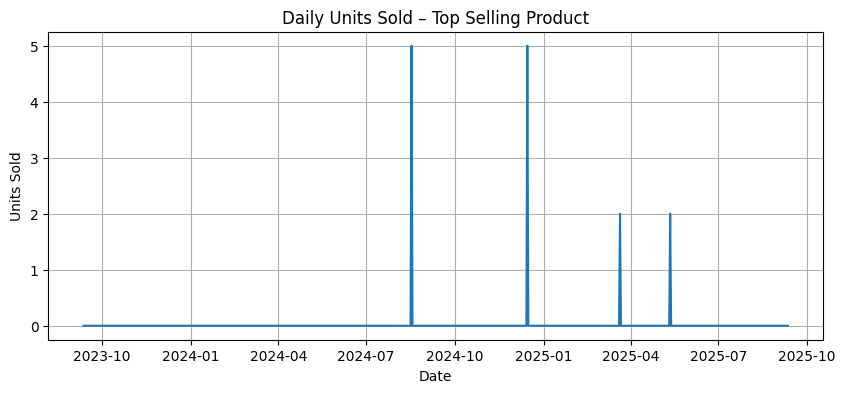

Train length: 584 Test length: 147


In [ ]:
series = fact_sales.set_index('date_key')['units_sold']

plt.figure(figsize=(10,4))
plt.plot(series.index, series.values)
plt.title(f'Daily Units Sold – {target_name}')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.grid(True)
plt.show()

train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

print("Train length:", len(train), "Test length:", len(test))


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  584
Model:                        SARIMAX   Log Likelihood                -132.096
Date:                Wed, 19 Nov 2025   AIC                            268.192
Time:                        02:18:38   BIC                            276.932
Sample:                    09-12-2023   HQIC                           271.598
                         - 04-17-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0205      0.077      0.268      0.788      -0.130       0.171
sigma2         0.0920      0.003     31.354      0.000       0.086       0.098
Ljung-Box (L1) (Q):                   0.01   Jarque-

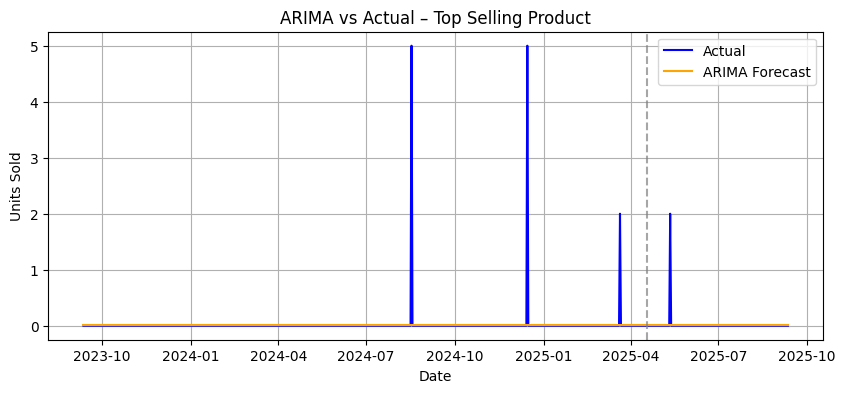

In [ ]:
# ARIMA
arima_model = auto_arima(
    train,
    seasonal=False,
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True
)

print(arima_model.summary())

fitted_train = pd.Series(arima_model.predict_in_sample(), index=train.index)

n_test = len(test)
forecast_test = arima_model.predict(n_periods=n_test)
forecast_test = pd.Series(forecast_test, index=test.index)

arima_full = pd.concat([fitted_train, forecast_test]).sort_index()

rmse_arima = sqrt(mean_squared_error(test, forecast_test))
mae_arima = mean_absolute_error(test, forecast_test)
mape_arima = np.mean(np.abs((test - forecast_test) / (test + 1e-6))) * 100

print("ARIMA RMSE:", rmse_arima)
print("ARIMA MAE :", mae_arima)
print("ARIMA MAPE:", mape_arima)

plt.figure(figsize=(10,4))
plt.plot(series.index, series.values, label='Actual', color='blue')
plt.plot(arima_full.index, arima_full.values, label='ARIMA Forecast', color='orange')
plt.axvline(x=test.index[0], color='gray', linestyle='--', alpha=0.7)
plt.title(f'ARIMA vs Actual – {target_name}')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM RMSE: 0.16860922699155848
LSTM MAE : 0.03652222154528967
LSTM MAPE: 2239984.9806943396


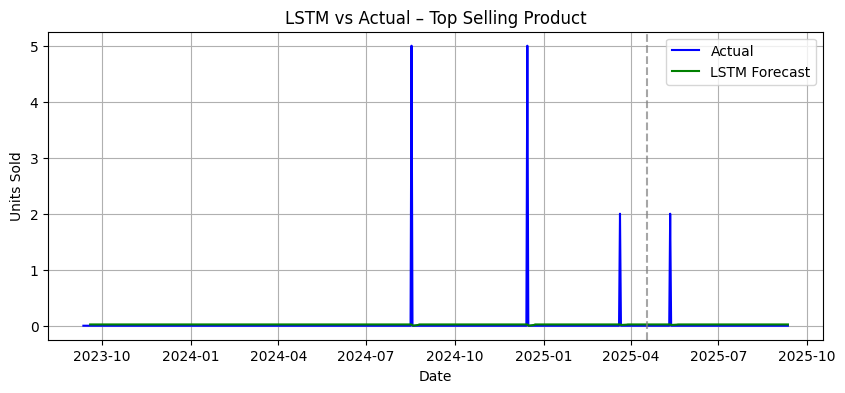

In [ ]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled  = scaler.transform(test.values.reshape(-1, 1))

def create_sequences(data, n_steps=7):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, 0])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 7
X_train, y_train = create_sequences(train_scaled, n_steps)
X_test,  y_test  = create_sequences(test_scaled,  n_steps)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='tanh', input_shape=(n_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Predictions on train and test
train_pred_scaled = lstm_model.predict(X_train)
test_pred_scaled  = lstm_model.predict(X_test)

train_pred = scaler.inverse_transform(train_pred_scaled).flatten()
test_pred  = scaler.inverse_transform(test_pred_scaled).flatten()

train_aligned = train.iloc[n_steps:]
test_aligned  = test.iloc[n_steps:]

lstm_train_series = pd.Series(train_pred, index=train_aligned.index)
lstm_test_series  = pd.Series(test_pred,  index=test_aligned.index)

lstm_full = pd.concat([lstm_train_series, lstm_test_series]).sort_index()

rmse_lstm = sqrt(mean_squared_error(test_aligned, test_pred))
mae_lstm  = mean_absolute_error(test_aligned, test_pred)
mape_lstm = np.mean(np.abs((test_aligned - test_pred) / (test_aligned + 1e-6))) * 100

print("LSTM RMSE:", rmse_lstm)
print("LSTM MAE :", mae_lstm)
print("LSTM MAPE:", mape_lstm)

plt.figure(figsize=(10,4))
plt.plot(series.index, series.values, label='Actual', color='blue')
plt.plot(lstm_full.index, lstm_full.values, label='LSTM Forecast', color='green')
plt.axvline(x=test.index[0], color='gray', linestyle='--', alpha=0.7)
plt.title(f'LSTM vs Actual – {target_name}')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()


RF RMSE: 0.1645936971507424
RF MAE : 0.0355318273105851
RF MAPE: 2208218.2843634486


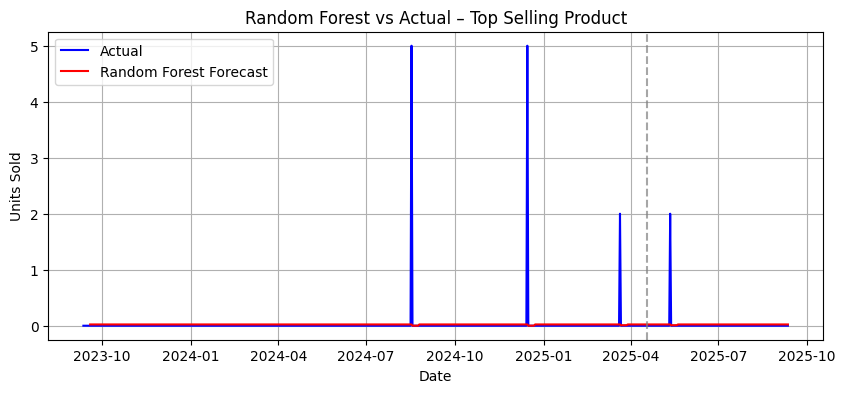

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def make_lag_df(series, n_lags=7):
    df = pd.DataFrame({'y': series})
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df = df.dropna()
    return df

n_lags = 7
lag_df = make_lag_df(series, n_lags=n_lags)

split_date = test.index[0]
lag_train = lag_df[lag_df.index < split_date]
lag_test  = lag_df[lag_df.index >= split_date]

X_train_rf = lag_train.drop(columns=['y']).values
y_train_rf = lag_train['y'].values
X_test_rf  = lag_test.drop(columns=['y']).values
y_test_rf  = lag_test['y'].values

rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_rf, y_train_rf)

rf_pred_test = rf_model.predict(X_test_rf)

rmse_rf = sqrt(mean_squared_error(y_test_rf, rf_pred_test))
mae_rf  = mean_absolute_error(y_test_rf, rf_pred_test)
mape_rf = np.mean(np.abs((y_test_rf - rf_pred_test) / (y_test_rf + 1e-6))) * 100

print("RF RMSE:", rmse_rf)
print("RF MAE :", mae_rf)
print("RF MAPE:", mape_rf)

rf_pred_all = rf_model.predict(lag_df.drop(columns=['y']).values)
rf_full_series = pd.Series(rf_pred_all, index=lag_df.index)

plt.figure(figsize=(10,4))
plt.plot(series.index, series.values, label='Actual', color='blue')
plt.plot(rf_full_series.index, rf_full_series.values,
         label='Random Forest Forecast', color='red')
plt.axvline(x=split_date, color='gray', linestyle='--', alpha=0.7)
plt.title(f'Random Forest vs Actual – {target_name}')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
comparison = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM', 'Random Forest'],
    'RMSE':  [rmse_arima, rmse_lstm, rmse_rf],
    'MAE':   [mae_arima,  mae_lstm,  mae_rf],
    'MAPE':  [mape_arima, mape_lstm, mape_rf]
})

# pick best model using lowest MAPE
best_idx = comparison['MAPE'].idxmin()
best_model_name = comparison.loc[best_idx, 'Model']

comparison['Best_Model'] = ''
comparison.loc[best_idx, 'Best_Model'] = '✓ best'

display(comparison)
print("Best model based on lowest MAPE:", best_model_name)


,Model,RMSE,MAE,MAPE,Best_Model
0,ARIMA,0.164542,0.033874,2.040817e+06,✓ best
1,LSTM,0.168609,0.036522,2.239985e+06,
2,Random Forest,0.164594,0.035532,2.208218e+06,


Best model based on lowest MAPE: ARIMA
